# Project 3, Runge-Kutta and 2-body orbital mechanics

**Devon DeJohn** | PHY 4611 | March 18, 2019

> This project explores one of the many physical systems in which the Euler integration method breaks down. In particular we plot the trajectory of Halley's comet, a highly elliptical comet with an orbital period of ~75 years. Elliptical orbits are of a type of system governed by "stiff" differential equations of motion, and as such do not play nicely with fixed-size timesteps.
>
> We start by demonstrating that even though Euler-Cromer conserves angular momentum, the scheme does not conserve energy and thus performs poorly for trajectories that are not nearly circular. We move on to the fourth-order Runge-Kutta method which performs admirably but remains too naïve for such a "stiff" system, and wastes computation time when orbits become highly elliptical. Finally we modify RK4 to be an adaptive algorithm, which adjusts its stepsize according to an energy-conservation-error threshold, and thus reduces the number of calculations necessary.


## 3.2—angular momentum iterated through Euler-Cromer

> Prove that for the Kepler problem the Euler-Cromer method conserves angular momentum exactly.

Let $v_{n+1} = v_n + a \,\tau$ and $r_{n+1} = r_n + v_{n+1} \,\tau$. Angular momentum is expressed as $L = r \times m\,v = m\,(r \times v)$, and in the two-body problem, $a_n = -\frac{\mu}{\|r_n\|^3} r_n$.
        
As above, the scalar $m$ can be factored to the outside of the cross product, and as such is omitted after the first line of the following for clarity. Other properties of the cross product are assumed, namely: $(a + b) \times c = (a \times c) + (b \times c)$ and $(a \times a) = 0$.

Then,

$$
\begin{align*}
    L_{n+1} &= m\,(r_{n+1} \times v_{n+1}) \\
    &= (r_n + v_{n+1} \tau) \times (v_n + a_n \,\tau) \\
    &= \big{(} r_n + (v_n + a_n \,\tau) \, \tau \big{)} \times (v_n + a_n \,\tau) \\
    &= \big{(} r_n \times (v_n + a_n \,\tau)\big{)} + \big{(}(v_n + a_n \,\tau)\,\tau \times (v_n + a_n \,\tau)\big{)} \\
    &= r_n \times (v_n + a_n\,\tau) \\
    &= (r_n \times v_n) + (r_n \times a_n\,\tau) \\
    &= (r_n \times v_n) -\frac{\tau \, \mu}{\|r_n\|^3} (r_n \times r_n) \\
    &= L_n
\end{align*}
$$

Thus stepwise angular momentum through Euler-Cromer is conserved exactly. Something I don't understand is how EC can conserve angular momentum exactly but still break down on elliptical orbits. How does this happen?

### Graph reproduction

Since I decided to implement my own Runge-Kutta routine I reproduced the graphs shown in the book, to make sure mine worked correctly.

euler maximum error: 69.20443% (tau = 0.02 yr)


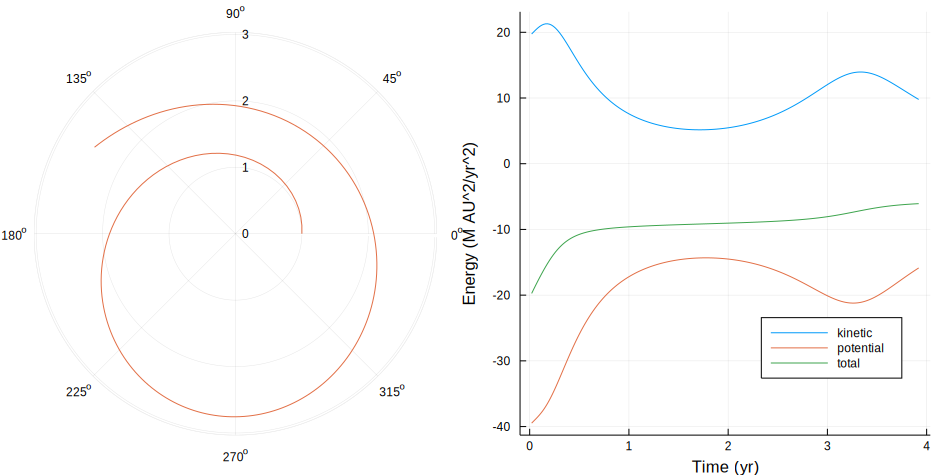

In [2]:
plot_orbit(get_orbit(State([1, 0], [0, 2*pi]), euler, 0.02, orb=4.))

cromer maximum error: 1.58495% (tau = 0.02 yr)


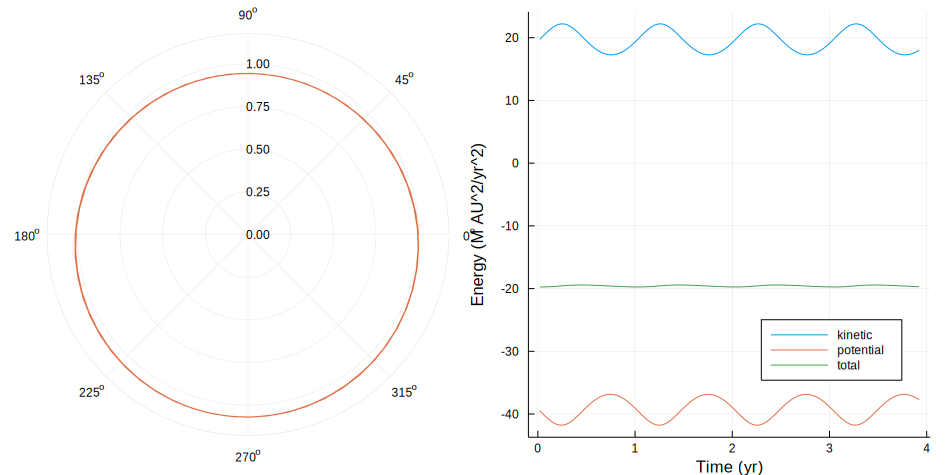

In [3]:
plot_orbit(get_orbit(State([1, 0], [0, 2*pi]), cromer, 0.02, orb=4.))

cromer maximum error: 79.76831% (tau = 0.005 yr)


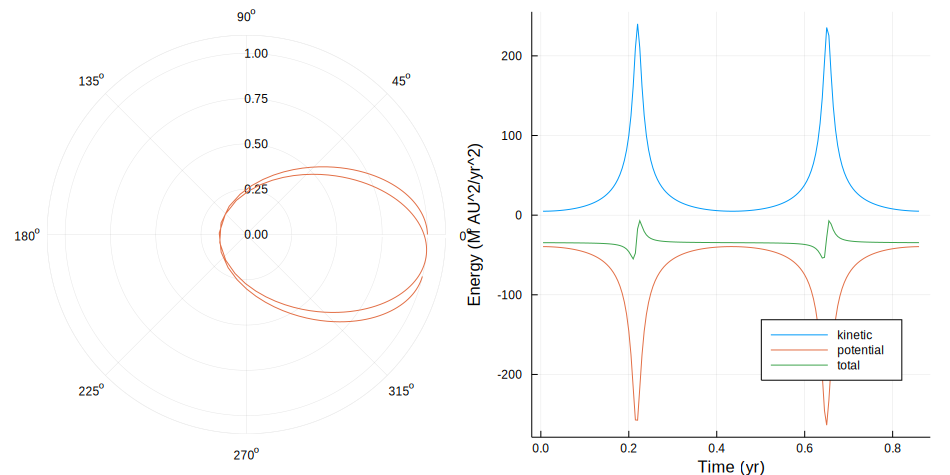

In [4]:
plot_orbit(get_orbit(State([1, 0], [0, pi]), cromer, 0.005))

## 3.6 + 3.11—maximum timestep for Euler-Cromer and RK4

> The Euler-Cromer method must use a small time step for the more elliptic orbits. Using an initial radial distance of 35 AU (Halley's comet) and various values for the aphelion velocity, find the largest value of $\tau$ for which the total energy is conserved to about 1% per orbit. Assemble a graph of $\tau$ versus initial velocity, and estimate the time step needed to track Halley's comet.

I combined the graph from this exercise with the next exercise, since all that changes is the integration method. I implemented a naive loop which starts with a timestep known to be too large (found through trial and error) and reduces the timestep to 99.5% of its previous value if at any point the total energy goes above the 1% error threshold.

This is a short-circuiting loop, so if the energy error is ever greater than 1% I throw the trajectory out and start over with the reduced timestep value. This method, combined with the 0.5% timestep reduction per attempt assures that the successful timesteps the function returns very close to the maximum value possible in order to remain under the 1% error threshold. It also runs quite fast, so I used 0.01 AU/yr increments

I found the log-log plot not particularly enlightening so I plotted only the y-axis on the log scale.

For the maximum timestep for RK4 from the graph produced I estimated between 0.015 and 0.016 years for the timestep. After some trial and error I narrowed it down to 0.01585 years. For the Euler-Cromer scheme, I estimated between 5e-5 and 7e-5 years. I narrowed this estimate down to 6e-5 years.

I decided not to include the plot for the Euler-Cromer integration because it was taking a crazy amount of memory to render and was dragging the whole notebook down to a crawl. Underneath the tau plot I show the maximum energy errors for the `RK4` and `Euler-Cromer` integrations with the aforementioned timestep values.

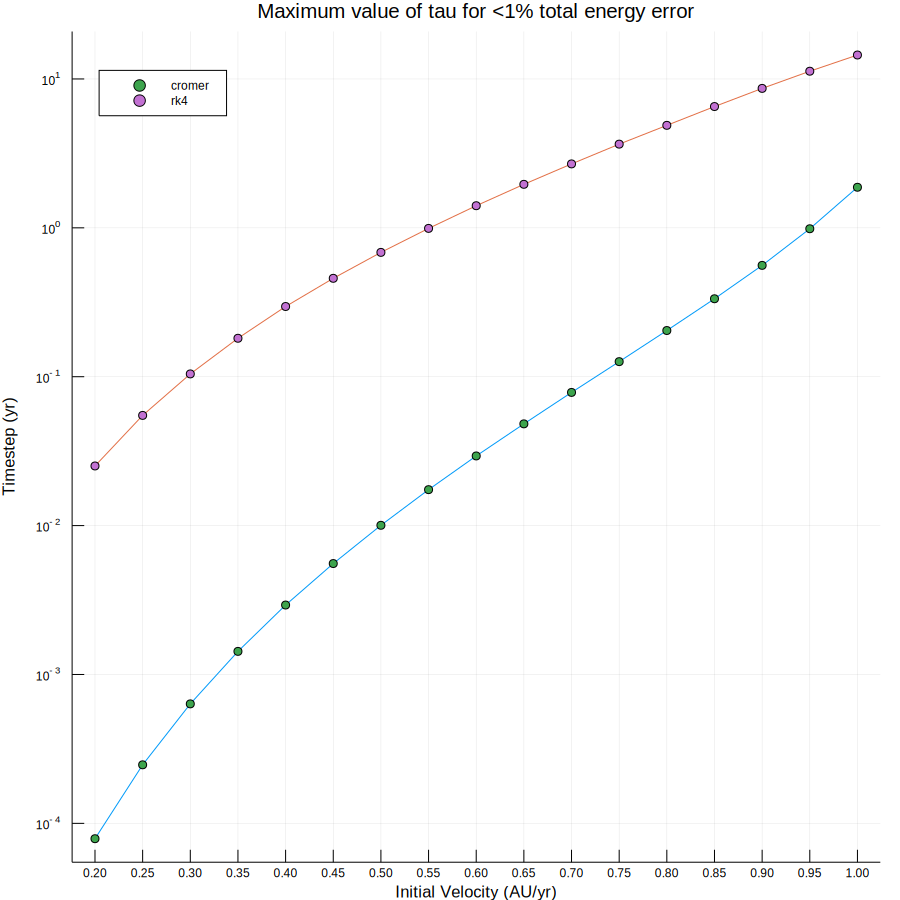

In [5]:
# Start Cromer with an initial timestep of 3 years.
cr_taus = get_best_tau(cromer, 3.)

# Start RK with an initial timestep of 15 years.
rk_taus = get_best_tau(rk4, 15.)

plot_taus(cr_taus, rk_taus)

In [6]:
hc = State([35, 0], [0, 0.19])
rko = get_orbit(hc, rk4, 0.01585, orb=4.)
cr = get_orbit(hc, cromer, 0.00006, orb=1.);

rk4 maximum error: 0.98131% (tau = 0.01585 yr)
cromer maximum error: 0.98632% (tau = 6.0e-5 yr)


## 3.14—orbital precession

> Consider the central force 
>
> $$F(r) = - \frac{\mu \; m}{r^3} \bigg{(} 1 - \frac{\alpha}{r} \bigg{)} \; \vec{r}$$
>
> where $\alpha$ is a constant. Modify the `orbit` program to compute the motion of an object under this force law. Using adaptive Runge-Kutta, show that the orbit precesses $360(1-a)/a$ degrees per revolution, where $a = \sqrt{1 + \mu m^2 \alpha / L^2}$ and $L$ is the angular momentum.

Let $\alpha = 0.1$ and consider Halley's comet, an orbit with an aphelion of $35$ AU and an initial tangential velocity of $0.19$ AU/yr. I've omitted the mass term in the following because for this program, Halley's comet is the unit mass. Then

\begin{align*}
    L = r \times v &= \langle 35, 0 \rangle \times \langle 0, 0.19 \rangle \\
    &= r_x \cdot v_y - r_y \cdot v_x \\
    &= 6.65
\end{align*}

and $L^2 = 44.2225$. So then $a = \sqrt{1 + \mu m^2 \alpha / L^2} = \sqrt{1 + 4\pi^2 (0.1)/44.2225} \approx 1.044$, and we expect our aphelion to precess at a rate of roughly `~15.2°` per orbit.

When I ran `RKA` I ended up getting `14.88°` and I think that's due to the fact that `RKA` is probably not going to hit aphelion precisely each time around the orbit, and so the maximum radial distance from the origin is slightly skewed from the actual aphelion distance.

Apsidal precession: ~14.8818°


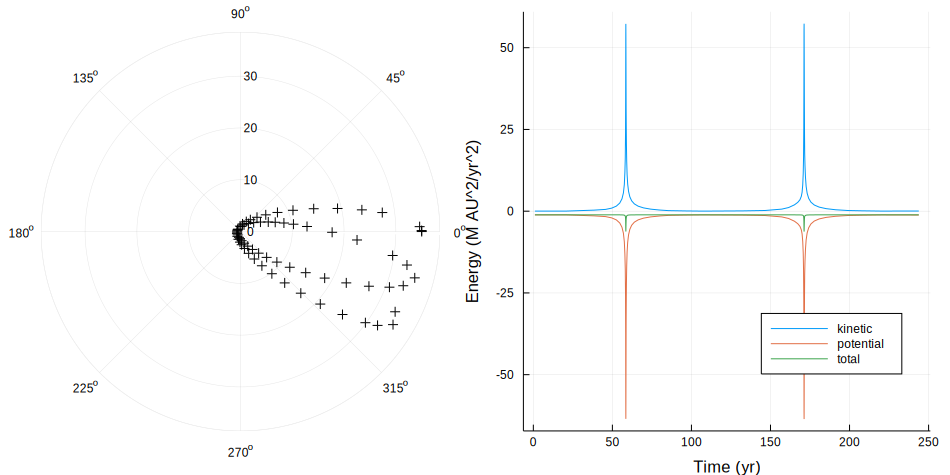

In [7]:
s = State([35,0], [0,0.19])
scatter_orbit(adaptive_orbit(s, 1., cf=pf, orb=3., prec=true))

## 3.15—drag force

> Modify `orbit` to add a drag force on the comet, $F_d = C|v|v$. Take the drag force to be small relative to the gravitational force $F_g$ by fixing the constant $C$ such that $|F_g(r_0)| = 100|F_d(v_0)|$, where $r_0$ and $v_0$ are the initial position and velocity, respectively. Show that the average kinetic energy (averaged over an orbit) *increases* with time.

My program lets the user input the desired number of orbits they'd like plotted, but the drag force obviously messes with the period of the orbit so my plots are no longer complete orbits but slightly longer. For my average kinetic energy plot I recorded the **rolling average** of kinetic energy over the course of the integration. I'm not sure if this is acceptable or not since the question asks for the average over just one orbit, but a steep upward trend is obvious in the plot and I didn't want to fiddle with the `orb` parameter until I could get something close to one orbit.

I suppose there's something to be said for the fact that the definition of a "complete" orbit when that orbit is unstable and decaying is a little ambiguous (in my opinion). I interpreted it to simply be whenever the true anomaly had swept through 360°.

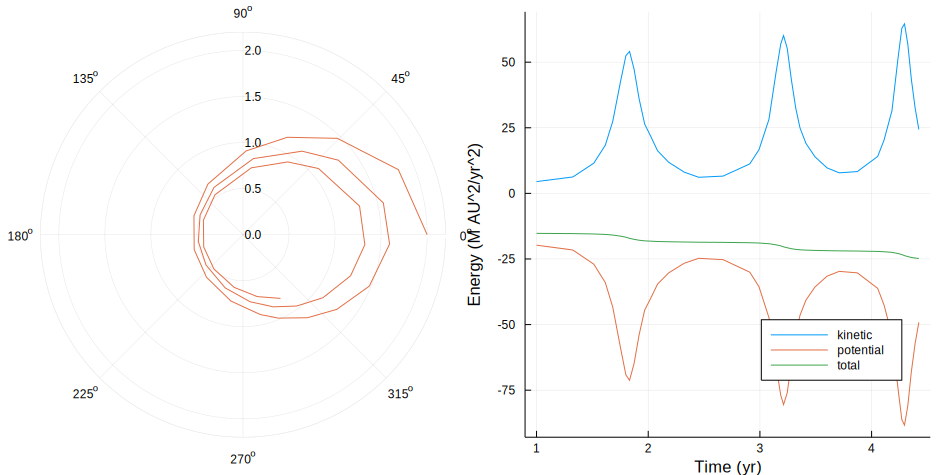

In [8]:
s = State([2,0], [0,3])
o = adaptive_orbit(s, 1., cf=df, orb=3.)
avgK = get_avg(o.K)
plot_orbit(o)

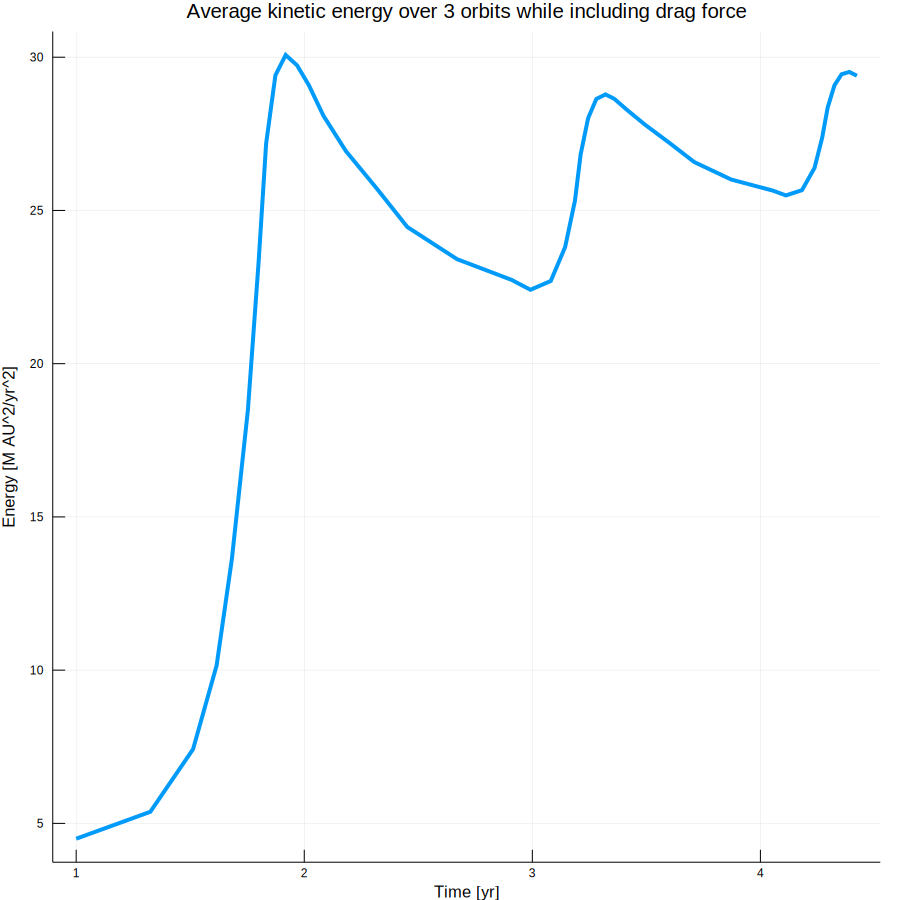

In [9]:
p = plot(size=(900,900), title="Average kinetic energy over 3 orbits while including drag force")
plot!(p, o.t, lw=4, avgK, label="", xlabel="Time [yr]", ylabel="Energy [M AU^2/yr^2]")

# Appendix A, code base

In [1]:
using Plots
using Printf
gr()

#——————————————————————————————————————————————————————————————————————————————————————————————————#
# Constants

const μ = 4*pi^2

#——————————————————————————————————————————————————————————————————————————————————————————————————#
# Orbital state vector

struct State
    r::AbstractVector{Float64}
    v::AbstractVector{Float64}
end

# Define scalar multiplication and addition on state vectors.
Base.:*(k::Number, S::State) = State(k*S.r, k*S.v)
Base.:+(A::State, B::State) = State(A.r + B.r, A.v + B.v)
Base.:-(A::State, B::State) = State(A.r - B.r, A.v - B.v)
Base.abs(s::State) = State([abs(i) for i in s.r], [abs(i) for i in s.v])

# Just a container for holding orbital data for plotting purposes.
struct Orbit
    ρ; θ; K; U; E; Ers; t
end

struct Taus_Vs 
    v; τ
end

#——————————————————————————————————————————————————————————————————————————————————————————————————#
# Helper functions

function nrm(r::AbstractVector{Float64})
    return sqrt(sum(r.^2))
end

function nrm(s::State)
    return sqrt(sum(vcat(s.r, s.v).^2))
end

function energy(X::State)
    k = 1/2*nrm(X.v)^2
    u = -μ/nrm(X.r)
    return (K=k, U=u, E=k+u)
end

function get_avg(K)
    avgK = []
    for i in 1:(size(K)[1])
        push!(avgK, sum(K[1:i])/i)
    end
    return avgK
end

function get_precession(pos, rho)
    r_max = findmax(rho[4:end])
    ap = pos[4:end][r_max[2]]
    return round(abs(atan(ap[2], ap[1]))*180/pi, digits=4)
end

function abs_error(exp, theo)
    return abs(100*(exp - theo)/theo)
end

# Returns an interpolated polynomial lambda.
function intrp(xx, yy)
    k = length(xx)
    if k != length(Set(xx))
        println("Cannot interpolate from duplicate x-values!")
    end

    function lbp(j, x)
        p = 1
        for m in 1:(k-1)
            p *= (x - xx[mod((j+m-1), k) + 1])/(xx[j] - xx[mod((j-m-1), k) + 1])
        end
        return p
    end

    return x -> sum(yy[j]*lbp(j, x) for j in 1:k)
end

#——————————————————————————————————————————————————————————————————————————————————————————————————#
# Central forces

function gf(args...)
    X, = args
    dr = X.v
    dv = -(μ/nrm(X.r)^3) * X.r
    return State(dr, dv)
end

function df(args...)
    X, k = args
    dr = X.v
    drag = k*nrm(X.v)*X.v
    dv = -(μ/nrm(X.r)^3)*X.r
    #println("central force: $(nrm(dv))")
    #println("drag force: $(nrm(drag))")
    return State(dr, dv-drag)
end

function pf(args...)
    X, = args
    r = nrm(X.r)
    v = nrm(X.v)
    α = 0.1
    
    dr = X.v
    dv = -(μ/r^3)*(1-α/r)*X.r
    return State(dr, dv)
end

#——————————————————————————————————————————————————————————————————————————————————————————————————#
# Integrators

function euler(X::State, τ::Float64)
    v = X.v -(τ*μ/nrm(X.r)^3) * X.r
    r = X.r + τ*X.v
    return State(r, v)
end

function cromer(X::State, τ::Float64)
    v = X.v -(τ*μ/nrm(X.r)^3) * X.r
    r = X.r + τ*v
    return State(r, v)
end

function rk(X::State, τ::Float64)
    return X + τ * f(X + τ/2 * f(X))
end

function rk4(X::State, τ::Float64, cf=gf, k=0.)
    F1 = cf(X, k)
    F2 = cf(X + τ/2*F1, k)
    F3 = cf(X + τ/2*F2, k)
    F4 = cf(X + τ*F3, k)

    return X + τ/6 * (F1 + F4 + 2*(F2 + F3))
end

function rka(X::State, τ::Float64, Δi::Float64, cf=gf, k=0.)
    s1 = 0.9
    s2 = 4.
    eps = 1e-15
    
    for i in 1:100        
        # do two half-tau RK4 steps
        X_s = rk4(rk4(X, τ/2, cf, k), τ/2, cf, k)

        # do one full-tau RK4 step
        X_b = rk4(X, τ, cf, k)
        
        # get diff
        scale = Δi/2 * (abs(X_s) + abs(X_b))
        scale = vcat(scale.r, scale.v)
        diff = vcat(X_s.r - X_b.r, X_s.v - X_b.v)        
        error_ratio = maximum(@. abs(diff)/(scale + eps))
        
        τ_old = τ
        τ = s1*τ_old*error_ratio^(-0.2)
        τ = max(τ, τ_old/s2)
        τ = min(τ, s2*τ_old)
        
        if error_ratio < 1.
            return (X_s, τ)
        end
    end
    
    error("Error, adaptive Runge-Kutta failed")
end

#——————————————————————————————————————————————————————————————————————————————————————————————————#
# Plotting

function adaptive_orbit(s::State, τ=0.005, Δi=0.003; cf=gf, orb=2, prec=false)
    # Initial total energy, against which we compare total energy through trajectory.
    E_i = energy(s).E
    
    r = nrm(s.r)
    v = nrm(s.v)
    k = nrm(-(μ/r^3)*s.r)/(100*v^2)
#     println("k = $k")
    
    # Find period of orbit.
    a = r*μ/(2*μ - r*v^2)
    T = 2*pi*sqrt(a^3/μ)    
    time = 0.
    
    # Preallocate arrays for orbit data. SO UGLY.
    ρ = []
    θ = []
    K = []
    U = []
    E = []
    Ers = []
    t = []
    pos = []
    
    # Do orb number of orbits.
    while time < orb*T
        time += τ
        nrg = energy(s)
        err = abs_error(nrg.E, E_i)
        
        # GROSS AWFUL CODE.
        push!(pos, s.r)
        push!(ρ, nrm(s.r))
        push!(θ, atan(s.r[2], s.r[1]))
        push!(K, nrg.K)
        push!(U, nrg.U)
        push!(E, nrg.E)
        push!(Ers, err)
        push!(t, time)
        rk_res = rka(s, τ, Δi, cf, k)
        s = rk_res[1]
        τ = rk_res[2]
    end
    
    if prec
        println("Apsidal precession: ~$(get_precession(pos, ρ))°")
    end
        
    return Orbit(ρ, θ, K, U, E, Ers, t)
end

function get_orbit(s::State, method=rk4, τ=0.005; cf=gf, orb=2.)   
    # Initial total energy, against which we compare total energy through trajectory.
    E_i = energy(s).E
    
    r = nrm(s.r)
    v = nrm(s.v)
    
    # Find period of orbit.
    a = r*μ/(2*μ - r*v^2)
    T = 2*pi*sqrt(a^3/μ)
    time = 0.

    # Divide period of orbit by tau to get evenly spaced steps; do orb number of orbits.
    steps = convert(Int64, orb*div(T, τ))
    
    # Preallocate arrays for orbit data.
    ρ = Array{Float64}(undef, steps)
    θ = Array{Float64}(undef, steps)
    K = Array{Float64}(undef, steps)
    U = Array{Float64}(undef, steps)
    E = Array{Float64}(undef, steps)
    Ers = Array{Float64}(undef, steps)
    t = Array{Float64}(undef, steps)
    
    # Begin trajectory calcs.
    for i in 1:steps
        time += τ
        nrg = energy(s)
        err = abs_error(nrg.E, E_i)
        ρ[i], θ[i], K[i], U[i], E[i], Ers[i], t[i] = nrm(s.r), atan(s.r[2], s.r[1]), nrg.K, nrg.U, nrg.E, err, time  
        s = method(s, τ)
    end
    
    max_err = round(maximum(Ers), digits=5)
    println("$(string(method)) maximum error: $(max_err)% (tau = $(τ) yr)")
    
    return Orbit(ρ, θ, K, U, E, Ers, t)
end

function propagate(s::State, v, τ, gf, method)
    # Find period of orbit.
    r = 35.
    a = r*μ/(2*μ - r*v^2)
    T = 2*pi*sqrt(a^3/μ)

    # Divide period of orbit by tau to get evenly spaced steps; do one full orbit.
    steps = div(T, τ)

    # Save initial state if we get a bad trajectory (err > 1%).
    S_i = s

    # Initial total energy, against which we compare total energy through trajectory.
    E_i = energy(s).E
    Ers = []

    # Initialize the error term.
    err = 0.

    # Flag used to recall if bad trajectory is found.
    bad_traj = false

    # Begin trajectory calcs.
    for i in 1:steps
        err = abs_error(energy(s).E, E_i)

        # Short-circuit if we get a bad trajectory.
        if err > 1.
            bad_traj = true
            break
        else
            push!(Ers, err)
            s = method(s, τ)
        end
    end

    if bad_traj
        # Start over with 99.5% of original tau if bad trajectory found.
        propagate(S_i, v, τ*0.995, gf, method)
    else
        return τ
    end
end

function get_best_tau(method, τ)
    vels = []
    taus = []
    
    for v in 1.0:-0.05:0.20
        # Try to push a good tau into the array.
        τ = propagate(State([35.,0.], [0., v]), v, τ, gf, method)
        push!(taus, τ)
        push!(vels, v)
    end
    
    return Taus_Vs(vels, taus)
end

function plot_orbit(o::Orbit)
    p1 = plot([0], [0], label=:"", proj=:polar)
    p2 = plot(o.t, o.K, label=:"kinetic", 
                yaxis=:"Energy (M AU^2/yr^2)", xaxis=:"Time (yr)",
                legend=:bottomright)

    plot!(p1, o.θ, o.ρ, label=:"")
    plot!(p2, o.t, o.U, label=:"potential")
    plot!(p2, o.t, o.E, label=:"total")
    plot(p1, p2, size=(950,475))
end

function scatter_orbit(o::Orbit)  
    p1 = plot([0], [0], label=:"", proj=:polar)
    p2 = plot(o.t, o.K, label=:"kinetic", 
                yaxis=:"Energy (M AU^2/yr^2)", xaxis=:"Time (yr)",
                legend=:bottomright)

    scatter!(p1, o.θ, o.ρ, m=:+, label=:"")
    plot!(p2, o.t, o.U, label=:"potential")
    plot!(p2, o.t, o.E, label=:"total")
    plot(p1, p2, size=(950,475))
end

function plot_taus(T1::Taus_Vs, T2::Taus_Vs)
    hspace = [v for v in T1.v]
    p = scatter(size=(900,900), title="Maximum value of tau for <1% total energy error",
            xaxis=("Initial Velocity (AU/yr)"), xticks=[i for i in 0.2:0.05:1.0],
            yaxis=(:log, "Timestep (yr)"),
            legend=:topleft)
    plot!(p, hspace, T1.τ, label=:"")
    plot!(p, hspace, T2.τ, label=:"")
    scatter!(p, hspace, T1.τ, label=:"cromer")
    scatter!(p, hspace, T2.τ, label=:"rk4")
    plot(p)
end;